In [57]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import pickle
from sklearn.preprocessing import OneHotEncoder,StandardScaler,LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report
from sklearn.model_selection import train_test_split,GridSearchCV

In [3]:
df = pd.read_csv('Crop_recommendation.csv')

In [4]:
df

,N,P,K,temperature,humidity,ph,rainfall,label
0,90,42,43,20.879744,82.002744,6.502985,202.935536,rice
1,85,58,41,21.770462,80.319644,7.038096,226.655537,rice
2,60,55,44,23.004459,82.320763,7.840207,263.964248,rice
3,74,35,40,26.491096,80.158363,6.980401,242.864034,rice
4,78,42,42,20.130175,81.604873,7.628473,262.717340,rice
...,...,...,...,...,...,...,...,...
2195,107,34,32,26.774637,66.413269,6.780064,177.774507,coffee
2196,99,15,27,27.417112,56.636362,6.086922,127.924610,coffee
2197,118,33,30,24.131797,67.225123,6.362608,173.322839,coffee
2198,117,32,34,26.272418,52.127394,6.758793,127.175293,coffee


In [5]:
l = LabelEncoder()
df['label_num'] = l.fit_transform(df['label'])

In [8]:
df['label'].value_counts()

label
rice           100
maize          100
jute           100
cotton         100
coconut        100
papaya         100
orange         100
apple          100
muskmelon      100
watermelon     100
grapes         100
mango          100
banana         100
pomegranate    100
lentil         100
blackgram      100
mungbean       100
mothbeans      100
pigeonpeas     100
kidneybeans    100
chickpea       100
coffee         100
Name: count, dtype: int64

In [11]:
X = df.drop(['label','label_num'],axis=1)
y = df['label_num']

In [12]:
X_train, X_test, y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [13]:
s = StandardScaler()
X_train = s.fit_transform(X_train)
X_test = s.transform(X_test)

In [31]:
rf = RandomForestClassifier(random_state=42)

In [32]:
param_grid = {
    'n_estimators': [100, 150, 200],
    'max_depth': [None, 10, 15, 20],
    'min_samples_split': [2, 5, 7, 9],
    'min_samples_leaf': [1, 2, 3, 5],
    'bootstrap': [True, False]
}

In [33]:
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid,
                           cv=5, n_jobs=-1, verbose=1)

In [34]:
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 384 candidates, totalling 1920 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'max_depth': [None, 10, 15, 20],
                         'min_samples_leaf': [1, 2, 3, 5],
                         'min_samples_split': [2, 5, 7, 9],
                         'n_estimators': [100, 150, 200]},
             verbose=1)

In [35]:
print("Best Parameters:\n", grid_search.best_params_)

Best Parameters:
 {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 150}


In [42]:
best_rf = grid_search.best_estimator_

In [44]:
y_pred = best_rf.predict(X_test)

In [45]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.9931818181818182
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        23
           1       1.00      1.00      1.00        21
           2       1.00      1.00      1.00        20
           3       1.00      1.00      1.00        26
           4       1.00      1.00      1.00        27
           5       1.00      1.00      1.00        17
           6       1.00      1.00      1.00        17
           7       1.00      1.00      1.00        14
           8       0.92      1.00      0.96        23
           9       1.00      1.00      1.00        20
          10       0.92      1.00      0.96        11
          11       1.00      1.00      1.00        21
          12       1.00      1.00      1.00        19
          13       1.00      0.96      0.98        24
          14       1.00      1.00      1.00        19
          15       1.00      1.00      1.00        17
          16       1.00     

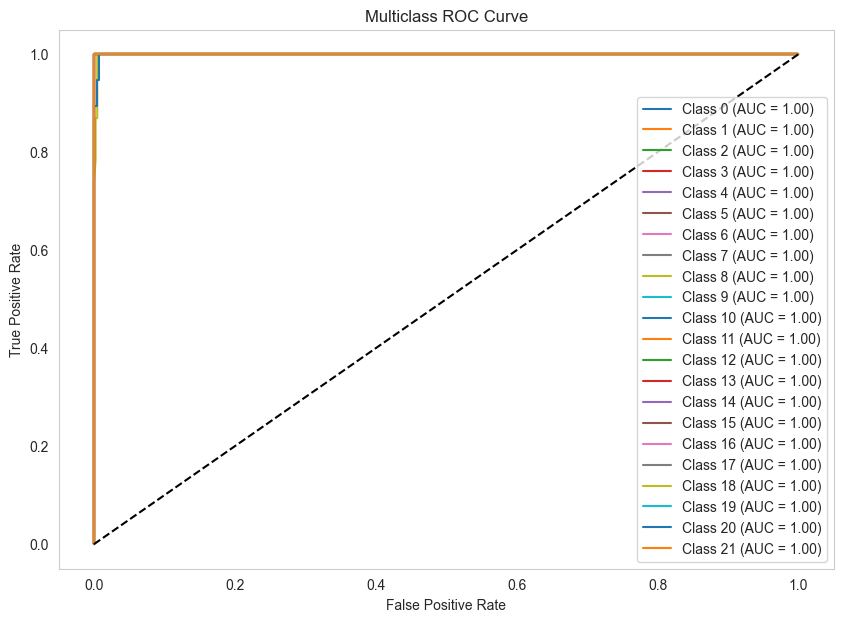

In [48]:
# Binarize the output labels
y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
n_classes = y_test_bin.shape[1]

# Get prediction probabilities
y_score = best_rf.predict_proba(X_test)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(10, 7))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

In [49]:
# Training predictions
y_train_pred = best_rf.predict(X_train)

# Test predictions
y_test_pred = best_rf.predict(X_test)

In [50]:
from sklearn.metrics import accuracy_score

train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy:     {test_accuracy:.4f}")

Training Accuracy: 1.0000
Test Accuracy:     0.9932


In [52]:
# Predict encoded labels
y_pred_encoded = best_rf.predict(X_test)

# Inverse transform to original labels
y_pred_original = l.inverse_transform(y_pred_encoded)

In [53]:
y_pred_original

array(['muskmelon', 'watermelon', 'papaya', 'papaya', 'apple', 'mango',
       'apple', 'mothbeans', 'mungbean', 'lentil', 'blackgram', 'coconut',
       'pomegranate', 'jute', 'coconut', 'pomegranate', 'apple', 'maize',
       'papaya', 'muskmelon', 'coffee', 'papaya', 'orange', 'papaya',
       'chickpea', 'jute', 'mungbean', 'orange', 'pigeonpeas', 'rice',
       'pomegranate', 'mothbeans', 'jute', 'lentil', 'jute', 'blackgram',
       'jute', 'chickpea', 'chickpea', 'kidneybeans', 'papaya', 'mango',
       'blackgram', 'maize', 'mungbean', 'maize', 'pigeonpeas', 'coconut',
       'muskmelon', 'maize', 'blackgram', 'coffee', 'grapes', 'mungbean',
       'coffee', 'kidneybeans', 'cotton', 'apple', 'banana', 'blackgram',
       'watermelon', 'coconut', 'lentil', 'orange', 'papaya',
       'pigeonpeas', 'orange', 'rice', 'muskmelon', 'pigeonpeas',
       'muskmelon', 'coconut', 'jute', 'banana', 'blackgram', 'papaya',
       'banana', 'cotton', 'watermelon', 'orange', 'coffee', 'chickp

In [56]:
joblib.dump(best_rf, 'best_random_forest_model.pkl')

['best_random_forest_model.pkl']

In [61]:
with open('l.pkl','wb') as file:
    pickle.dump(l,file)

In [60]:
with open('s.pkl','wb') as file:
    pickle.dump(s,file)